# Cholec80 Dataset - Data Loading and Visualization

This notebook demonstrates:
1. Loading the Cholec80 dataset using our PyTorch Dataset
2. Inspecting dataset statistics
3. Visualizing frames with their phase and tool annotations

In [35]:
import sys
import os

# Add the dataset module to path
sys.path.append('../src/dataset/cholec80')

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

from util_dataset import Cholec80Dataset, make_cholec80, PHASE_NAMES, TOOL_NAMES

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
PyTorch version: 2.8.0
CUDA available: False


## 1. Load the Dataset

Load the Cholec80 manifest CSV and create a PyTorch dataset.

In [36]:
# Path to your manifest CSV (now saved in the cholec80 module directory)
manifest_csv = '../src/dataset/cholec80/cholec80_manifest.csv'

# Import transforms
from torchvision import transforms

# Define a basic transform to convert PIL images to tensors
basic_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor (C, H, W) with values [0, 1]
])

# Create dataset with transform
dataset = Cholec80Dataset(
    manifest_csv=manifest_csv,
    transform=basic_transform,  # Now images will be tensors!
    return_video_info=True  # Include video_id and frame_id in output
)

print(f"\n✓ Dataset loaded successfully!")
print(f"Total samples: {len(dataset)}")

Loaded Cholec80 dataset:
  - 14266 frames
  - 5 videos
  - Phase distribution:
      0: Preparation                    -   7383 frames
      1: CalotTriangleDissection        -   6883 frames

✓ Dataset loaded successfully!
Total samples: 14266


## 2. Inspect Dataset Statistics

Let's look at the distribution of phases and tools across the dataset.

In [37]:
# Load the CSV to analyze
df = pd.read_csv(manifest_csv)

print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

print(f"\nTotal frames: {len(df)}")
print(f"Number of videos: {df['video_id'].nunique()}")
print(f"Videos included: {sorted(df['video_id'].unique())}")

print("\n" + "=" * 60)
print("PHASE DISTRIBUTION")
print("=" * 60)
phase_counts = df['phase'].value_counts().sort_index()
for phase_id, count in phase_counts.items():
    phase_name = PHASE_NAMES[phase_id]
    percentage = 100 * count / len(df)
    print(f"Phase {phase_id} - {phase_name:30s}: {count:6d} frames ({percentage:5.2f}%)")

print("\n" + "=" * 60)
print("TOOL DISTRIBUTION")
print("=" * 60)
tool_columns = ['grasper', 'bipolar', 'hook', 'scissors', 'clipper', 'irrigator', 'specimen_bag']
for i, tool_col in enumerate(tool_columns):
    count = df[tool_col].sum()
    percentage = 100 * count / len(df)
    print(f"{TOOL_NAMES[i]:15s}: {int(count):6d} frames ({percentage:5.2f}%)")

DATASET STATISTICS

Total frames: 14266
Number of videos: 5
Videos included: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

PHASE DISTRIBUTION
Phase 0 - Preparation                   :   7383 frames (51.75%)
Phase 1 - CalotTriangleDissection       :   6883 frames (48.25%)

TOOL DISTRIBUTION
Grasper        :   9693 frames (67.94%)
Bipolar        :      0 frames ( 0.00%)
Hook           :   6553 frames (45.93%)
Scissors       :   1252 frames ( 8.78%)
Clipper        :      0 frames ( 0.00%)
Irrigator      :      0 frames ( 0.00%)
SpecimenBag    :      0 frames ( 0.00%)


## 3. Visualize Class Distributions

Plot the distribution of phases and tools as bar charts.

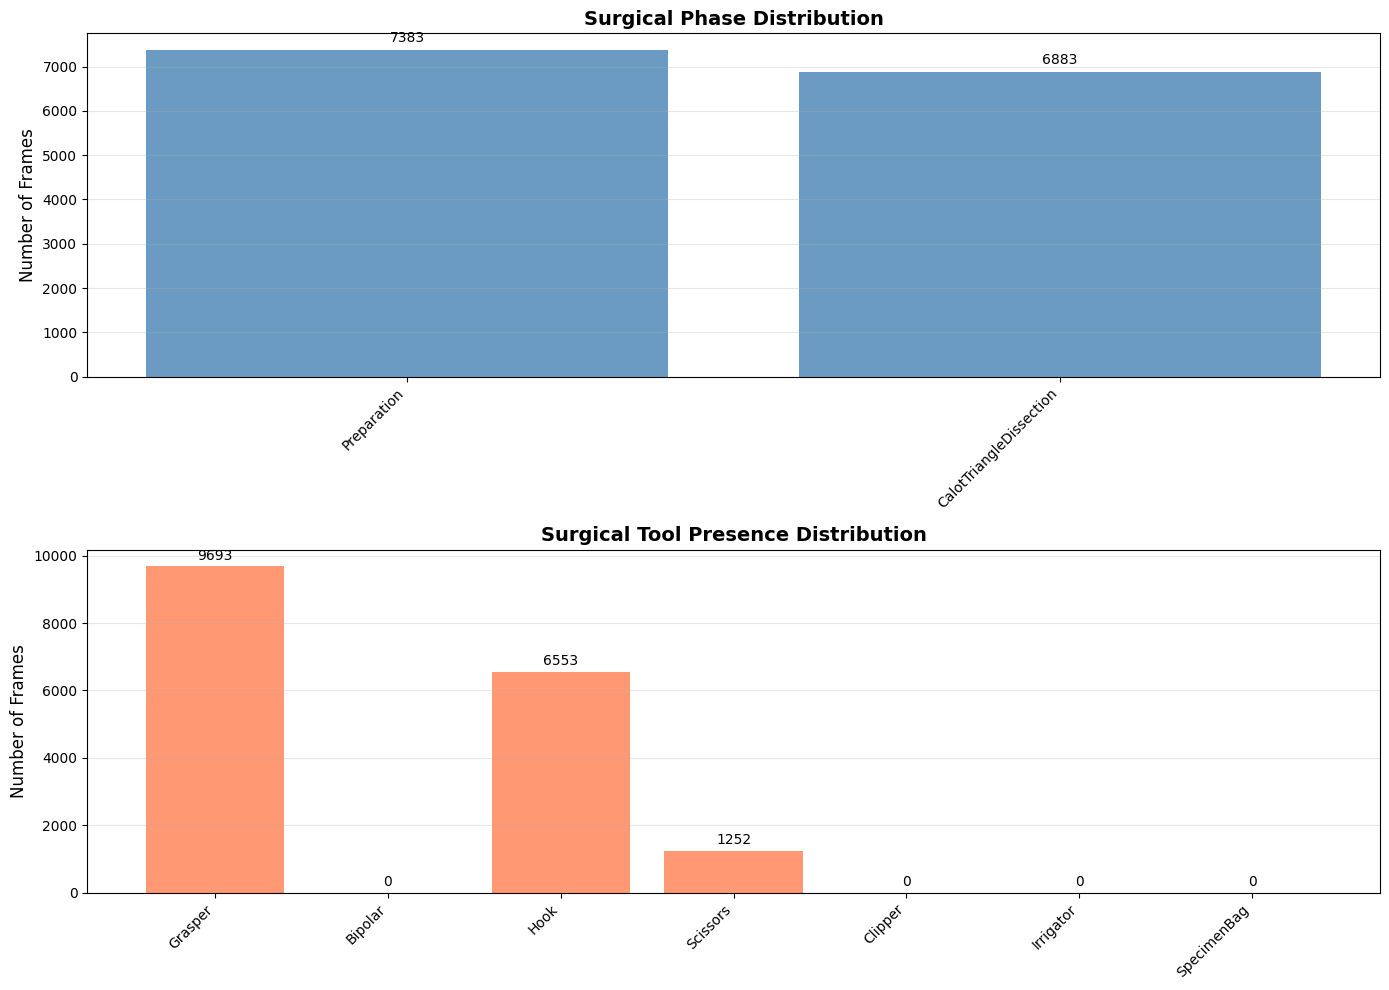

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot phase distribution
phase_counts = df['phase'].value_counts().sort_index()
phase_labels = [PHASE_NAMES[i] for i in phase_counts.index]

axes[0].bar(range(len(phase_counts)), phase_counts.values, color='steelblue', alpha=0.8)
axes[0].set_xticks(range(len(phase_counts)))
axes[0].set_xticklabels(phase_labels, rotation=45, ha='right')
axes[0].set_ylabel('Number of Frames', fontsize=12)
axes[0].set_title('Surgical Phase Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, count in enumerate(phase_counts.values):
    axes[0].text(i, count + 100, str(count), ha='center', va='bottom', fontsize=10)

# Plot tool distribution
tool_counts = [df[col].sum() for col in tool_columns]

axes[1].bar(range(len(TOOL_NAMES)), tool_counts, color='coral', alpha=0.8)
axes[1].set_xticks(range(len(TOOL_NAMES)))
axes[1].set_xticklabels(TOOL_NAMES, rotation=45, ha='right')
axes[1].set_ylabel('Number of Frames', fontsize=12)
axes[1].set_title('Surgical Tool Presence Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, count in enumerate(tool_counts):
    axes[1].text(i, count + 100, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 4. Visualize Sample Frames

Load and display random frames with their annotations.

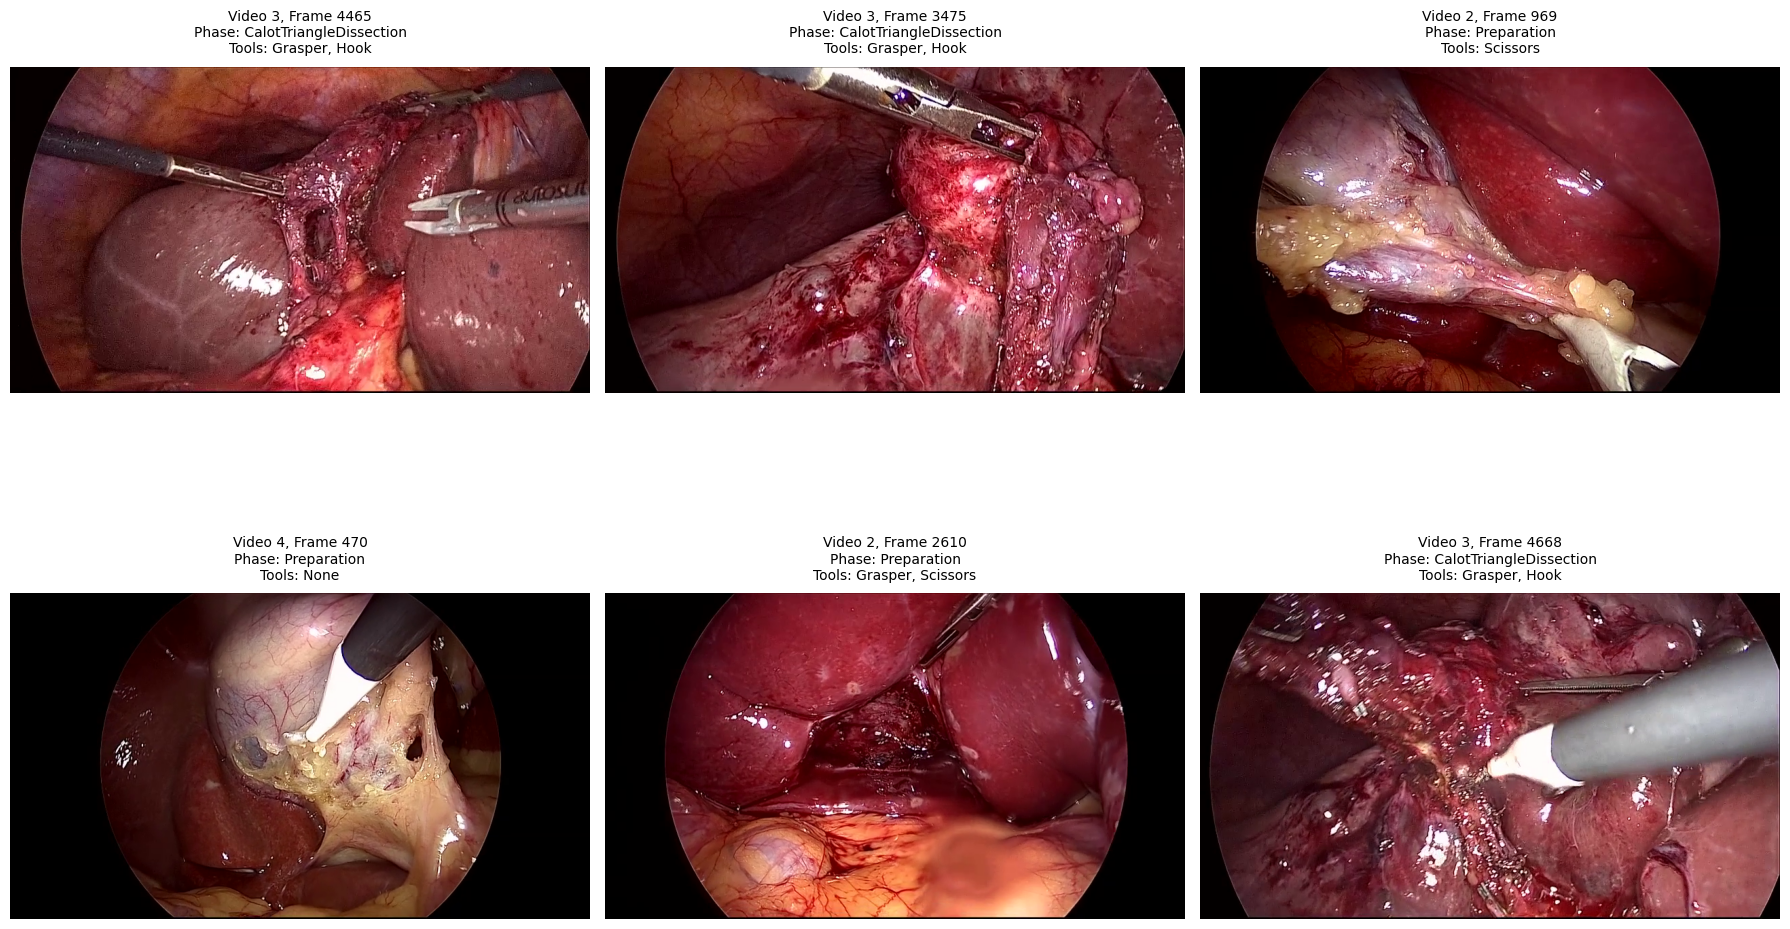

In [39]:
def visualize_samples(dataset, num_samples=6, seed=42):
    """
    Visualize random samples from the dataset with their annotations
    """
    np.random.seed(seed)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Calculate grid dimensions
    cols = 3
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten() if num_samples > 1 else [axes]
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        
        # Get data
        image = sample['image']
        phase = sample['phase'].item()
        tools = sample['tools'].numpy()
        video_id = sample['video_id']
        frame_id = sample['frame_id']
        
        # Convert to numpy for display
        if torch.is_tensor(image):
            # Convert from (C, H, W) tensor to (H, W, C) numpy array
            image = image.permute(1, 2, 0).numpy()
        elif isinstance(image, Image.Image):
            image = np.array(image)
        
        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        
        # Get active tools
        active_tools = [TOOL_NAMES[j] for j in range(len(tools)) if tools[j] == 1]
        tools_str = ", ".join(active_tools) if active_tools else "None"
        
        # Create title with annotations
        title = f"Video {video_id}, Frame {frame_id}\n"
        title += f"Phase: {PHASE_NAMES[phase]}\n"
        title += f"Tools: {tools_str}"
        
        axes[i].set_title(title, fontsize=10, pad=10)
    
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 6 random samples
visualize_samples(dataset, num_samples=6)

## 5. Test DataLoader with Batching

Create a DataLoader and iterate through a batch to verify everything works.

In [40]:
# Create a simple DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0  # Set to 0 for notebook compatibility
)

# Get one batch
batch = next(iter(dataloader))

print("=" * 60)
print("DATALOADER TEST")
print("=" * 60)
print(f"\nBatch size: {len(batch['phase'])}")
print(f"\nBatch contents:")
print(f"  - Images: {type(batch['image'])} (note: PIL images in a list)")
print(f"  - Phases: {batch['phase'].shape} - {batch['phase'].dtype}")
print(f"  - Tools: {batch['tools'].shape} - {batch['tools'].dtype}")
print(f"  - Video IDs: {batch['video_id']}")
print(f"  - Frame IDs: {batch['frame_id'][:5]}... (showing first 5)")

print("\n" + "=" * 60)
print("SAMPLE BATCH DATA")
print("=" * 60)
print(f"\nPhases in this batch:")
for i, phase_id in enumerate(batch['phase'][:5]):  # Show first 5
    print(f"  Sample {i}: Phase {phase_id.item()} - {PHASE_NAMES[phase_id.item()]}")

print(f"\nTools in this batch (first sample):")
tools_first = batch['tools'][0].numpy()
active_tools = [TOOL_NAMES[j] for j in range(len(tools_first)) if tools_first[j] == 1]
print(f"  Active tools: {', '.join(active_tools) if active_tools else 'None'}")

DATALOADER TEST

Batch size: 8

Batch contents:
  - Images: <class 'torch.Tensor'> (note: PIL images in a list)
  - Phases: torch.Size([8]) - torch.int64
  - Tools: torch.Size([8, 7]) - torch.float32
  - Video IDs: tensor([4, 5, 3, 3, 4, 2, 1, 2])
  - Frame IDs: tensor([  70, 2258, 2296,  601,  857])... (showing first 5)

SAMPLE BATCH DATA

Phases in this batch:
  Sample 0: Phase 0 - Preparation
  Sample 1: Phase 1 - CalotTriangleDissection
  Sample 2: Phase 1 - CalotTriangleDissection
  Sample 3: Phase 0 - Preparation
  Sample 4: Phase 0 - Preparation

Tools in this batch (first sample):
  Active tools: None


## 6. Visualize Batch of Images

Display multiple images from a single batch.

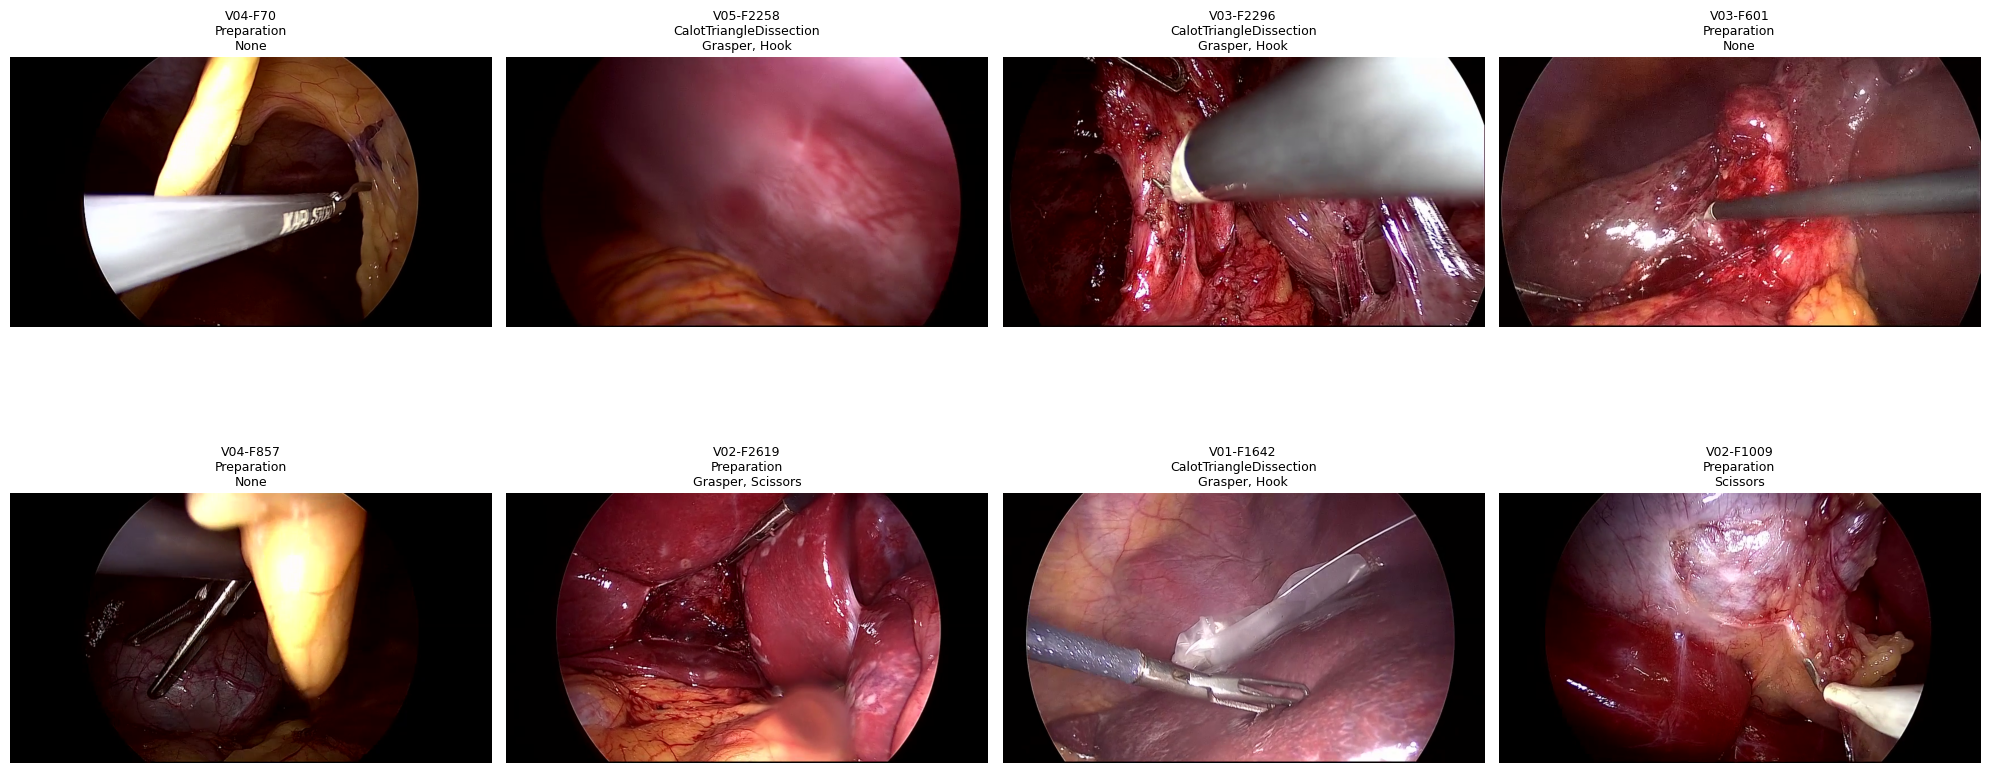

In [41]:
def visualize_batch(batch, num_images=8):
    """
    Visualize images from a batch
    """
    num_images = min(num_images, len(batch['phase']))
    
    cols = 4
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for i in range(num_images):
        # Get data
        image = batch['image'][i]
        phase = batch['phase'][i].item()
        tools = batch['tools'][i].numpy()
        video_id = batch['video_id'][i]
        frame_id = batch['frame_id'][i]
        
        # Convert to numpy for display
        if torch.is_tensor(image):
            # Convert from (C, H, W) tensor to (H, W, C) numpy array
            image = image.permute(1, 2, 0).numpy()
        elif isinstance(image, Image.Image):
            image = np.array(image)
        
        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        
        # Get active tools
        active_tools = [TOOL_NAMES[j] for j in range(len(tools)) if tools[j] == 1]
        tools_str = ", ".join(active_tools) if active_tools else "None"
        
        # Create title
        title = f"V{video_id:02d}-F{frame_id}\n{PHASE_NAMES[phase]}\n{tools_str}"
        axes[i].set_title(title, fontsize=9, pad=5)
    
    # Hide unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the batch we just loaded
visualize_batch(batch, num_images=8)

## 8. Summary and Next Steps

✓ Successfully loaded the Cholec80 dataset  
✓ Inspected class distributions (phases and tools)  
✓ Visualized sample frames with annotations  
✓ Tested DataLoader batching  
✓ Calculated class imbalance weights  

**Next Steps:**
1. Create train/val/test splits (e.g., videos 1-60 for training)
2. Add image transforms (resize, normalization, augmentation)
3. Build a CNN model (ResNet, EfficientNet, custom architecture)
4. Train for phase recognition and/or tool detection
5. Evaluate performance on test set